#  Recommendation Systems

Load Pandas, we are going to need it for manipulating data

In [93]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from typing import Optional, List, Tuple, Dict, Any, NoReturn, Iterable, Union, Literal

import matplotlib.pyplot as plt

import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

%matplotlib inline

np.set_printoptions(precision=3)

_rng: np.random.Generator = np.random.default_rng(42)

In [94]:
print(pd.__version__)

1.4.1


In [95]:
colnames = ["rated"] + [i for i in range(1,101)]



data: pd.DataFrame = pd.read_csv(
    "jester-data-1.csv",
    #names=colnames,
    header=None
)
#data.drop("rated", axis=1, inplace=True)

data.drop(0, inplace=True)
data.replace(99, np.NaN, inplace=True)


data.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
1,100.0,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49.0,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,...,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,48.0,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,...,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,91.0,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
5,100.0,-6.17,-3.54,0.44,-8.50,-7.09,-4.32,-8.69,-0.87,-6.65,...,-3.54,-6.89,-0.68,-2.96,-2.18,-3.35,0.05,-9.08,-5.05,-3.45


In [96]:
print(data.shape)


(24982, 101)


In [97]:
means: pd.Series = data.mean()

print(means)

print(f"Highest rated: {means.idxmax()} {means[means.idxmax()]}")
print(f"Lowest  rated: {means.idxmin()} {means[means.idxmin()]}")


0      72.381109
1       0.905104
2       0.207988
3       0.317174
4      -1.448684
         ...    
96      1.528003
97      1.674444
98      0.767692
99     -0.031244
100     1.354711
Length: 101, dtype: float64
Highest rated: 0 72.38110919240191
Lowest  rated: 58 -3.833520447530864


In [98]:
original_data: pd.DataFrame = data.copy()

""

''

In [99]:
def make_validation_set(
        original: pd.DataFrame, replace_proportion: float = 0.1, replace_with: Any = 99
) -> Tuple[pd.DataFrame, Tuple[np.ndarray], Tuple[np.ndarray]]:
    """
    Creates a validation set version of the dataset.
    Obtains replace_proportion of the non NaN values in the dataset,
    and with those specific selected non-NaNs, replaces
    them with replace_with in that dataset.
    :param original: 
    :param size_percent: 
    :param replace_with:
    :return: 
    """
    valid_set: pd.DataFrame = original.copy()
    rated = np.where(~np.isnan(valid_set.values))
    n_rated: int = len(rated[0])
    replace_these = _rng.choice(n_rated, size=int(replace_proportion*n_rated), replace=False)

    print(replace_these)

    print(rated)



    valid_vals: np.ndarry = valid_set.values.flatten()
    valid_vals.flatten()[replace_these] = replace_with


    
    nintetynines = np.where(valid_vals==replace_with)

    print(nintetynines)

    #for x, y in zip(replace_these[0][i], ):
    #    valid_set[replace_these[i]]
    #valid_set.loc[rated[0][replace_these]],[rated[1][replace_these]] = replace_with
    return valid_set, (rated[0][replace_these], rated[1][replace_these])


def replace(orig, percentage=0.1, replace_with: Any = 99):
    """
    Replaces 'percentage'% of the original values in 'orig' with 99's
    :param orig: original data array
    :param percentage: percentage of values to replace (0<percentage<1)
    """
    #arr = orig.values
    arr = orig
    new_data = orig.copy()
    rated = np.where(arr!=99)
    n_rated = len(rated[0])
    idx = np.random.choice(
        n_rated,
        size=int(percentage*n_rated),
        replace=False
    )
    new_data[rated[0][idx], rated[1][idx]] = replace_with
    return new_data, (rated[0][idx], rated[1][idx])

new, (y, x) = replace(
    data.values, 0.1, 99
)

print(new)

[[100.     4.08  -0.29 ...   0.34  -4.32   1.07]
 [ 49.      nan    nan ...    nan    nan    nan]
 [ 48.      nan   8.35 ...    nan  99.      nan]
 ...
 [ 39.      nan    nan ...    nan    nan    nan]
 [ 37.      nan    nan ...    nan    nan    nan]
 [ 72.     2.43   2.67 ...    nan    nan    nan]]


In [100]:
new_df: pd.DataFrame = pd.DataFrame(data = new)

new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,100.0,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,...,2.82,-4.95,-0.29,99.00,-0.19,-2.14,3.06,0.34,-4.32,1.07
1,49.0,NaN,NaN,NaN,NaN,9.03,9.27,9.03,99.00,NaN,...,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
2,48.0,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,...,NaN,NaN,NaN,99.00,NaN,NaN,NaN,NaN,99.00,NaN
3,91.0,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,99.00,99.00
4,100.0,-6.17,-3.54,0.44,-8.50,-7.09,-4.32,99.00,-0.87,-6.65,...,-3.54,-6.89,-0.68,-2.96,-2.18,-3.35,0.05,-9.08,-5.05,-3.45


In [101]:



#validation

def predict_rating(user_row, item_row, user_preferences, item_factors):
    """ Predict a rating """
    user_values = user_preferences[user_row]
    item_values = item_factors[item_row]
    print(user_values)
    print(item_values)
    return user_values.dot(item_values)


def train(user_row, item_row, rating, user_preferences, item_factors, alpha=0.0001):
    """ Adapt the values of user_preferences and item_factors
    to match the ones predicted by the users
    """
    err = rating - predict_rating(user_row, item_row,  user_preferences, item_factors)
    temp = user_preferences.iloc[user_row]
    user_preferences.iloc[user_row] += alpha * err * item_factors.iloc[item_row]
    item_factors.iloc[item_row] += alpha * err * temp
    return err
    
    
    
def sgd_svd(user_preferences, item_factors, user_ratings, iterations=30000):
    mse_history = []
    for iteration in range(iterations):
        error = []
        for user_row in range(user_preferences.shape[0]):
            for item_row in range(item_factors.shape[0]):
                rating = columns.user_ratings[user_row][item_row]
                if not np.isnan(rating):
                    err = train(user_row, item_row, rating, user_preferences, item_factors)
                    error.append(err)
        
        mse = (np.array(error) ** 2).mean()
        if (iteration % 10) == 0:
            print('Iteration %d/%d:    MSE=%.3f' % (iteration, iterations, mse))
            mse_history.append(mse)
    return mse_history


def sgd(
        user_preferences,
        item_factors,
        user_ratings,
        iterations=30000,
        validation_val = 99,
        train_val = np.NaN
):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    mse_history = []
    for iteration in range(iterations):
        error = []
        
        for user_id in range(user_preferences.shape[0]):
            for item_id in range(item_factors.shape[0]):
                rating = user_ratings.values[user_id, item_id]
                print(user_id)
                print(item_id)
                print(rating)
                print(user_preferences[user_id].shape)
                print(item_factors[item_id].shape)
                #if not np.isnan(rating):
                if (not np.isnan(rating)) and (rating != train_val and rating != validation_val):
                    err = train(user_id, item_id, rating, user_preferences[user_id], item_factors[item_id])
                    error.append(err)
        mse = (np.array(error) ** 2).mean()   
        if (iteration % 10) == 0:
            print('Iteration %d/%d:    MSE=%.3f' % (iteration, iterations, mse))
            mse_history.append(mse)
    return mse_history


In [102]:
try:
    res = sgd(
        new_df.T.values,
        new_df.values,
        new_df
    )

    print(res)
except Exception:
    pass

0
0
100.0
(24982,)
(101,)
100.0
100.0


In [103]:
#df_jester.iloc[user_x, joke_y].

print(data.iloc[19928, 32])


6.02


In [130]:

movies_df: pd.DataFrame = pd.read_excel("movies_latent_factors.xlsx")

movies_df

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,11,Star Wars: Episode IV - A New Hope (1977),-1.521848,-1.038507,2.027269,0.247933,-0.594548,2.513260,-1.848910,0.476710,-0.224146,-0.760681,-0.973915,0.862379,0.403861,1.129616,-0.248806
1,12,Finding Nemo (2003),-0.342185,-0.296586,-0.385962,2.443297,-1.097015,-0.619465,0.572887,0.329516,-0.712228,0.323554,-0.561948,-0.142405,-0.564415,0.506876,1.274993
2,13,Forrest Gump (1994),-2.240888,-0.438815,-2.275177,0.614548,0.904469,0.711919,-0.420876,1.302036,-0.868418,-0.160122,0.633667,0.133138,-0.330276,-2.209004,-0.419092
3,14,American Beauty (1999),-0.634531,2.186059,-0.066681,0.086197,0.517558,-0.185319,-0.412352,0.063841,0.075937,-0.577682,0.526803,-1.465557,-0.819682,0.549010,-0.681191
4,22,Pirates of the Caribbean: The Curse of the Bla...,0.517348,-1.456763,0.369161,0.073903,-0.098332,-0.594722,0.828888,0.033626,-0.707414,0.717877,1.394326,-0.786986,1.429191,0.855746,-2.292566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,9806,The Incredibles (2004),0.159967,-0.051123,0.311183,1.841867,-1.952736,-0.836041,0.639252,-0.413082,-0.310868,0.448225,-0.846044,-0.158192,-0.649164,0.045580,1.017861
96,10020,Beauty and the Beast (1991),1.286288,0.004957,-0.157640,2.579640,-0.042687,-0.256582,-0.007971,0.458163,0.091394,0.323339,-0.862833,-0.508185,0.994535,0.868700,-0.487076
97,36657,X-Men (2000),0.811901,-0.893280,0.668953,-0.885074,-1.070468,-0.973154,-0.037449,-0.925609,-0.122112,-0.328822,-0.163103,-0.307299,0.642105,-1.355542,0.067790
98,36658,X2: X-Men United (2003),1.161006,-0.715613,0.712633,-0.688808,-0.717785,-1.007047,-0.267268,-0.802322,-0.249239,-0.540419,-0.291422,-0.240216,0.290714,-1.217250,-0.288130


In [131]:
movies_users: pd.DataFrame = pd.read_excel("movies_latent_factors.xlsx",sheet_name="Users")

movies_users


,User,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,4768,-0.204024,0.161079,-0.090447,0.138495,-0.162934,0.163894,0.051502,-0.088582,0.126829,0.065967,0.085008,0.355404,0.007108,-0.118663,-0.039125
1,156,-0.189652,-0.178979,-0.091490,-0.000823,-0.032646,0.177209,-0.098123,-0.068283,-0.011575,0.120866,-0.009931,-0.048606,0.045916,0.113671,0.179873
2,5323,-0.115308,-0.090886,-0.053129,0.018472,-0.068081,-0.004828,0.113005,0.102107,0.034758,0.000693,-0.073712,-0.019460,0.108372,0.054471,-0.109552
3,174,-0.227462,-0.272532,-0.017231,0.054324,0.214755,-0.072639,-0.033122,-0.086508,-0.131479,0.180403,0.095890,-0.082396,0.036767,-0.165438,0.050692
4,4529,-0.014616,-0.102218,-0.107935,0.155784,-0.123362,-0.118228,-0.013549,-0.050622,0.058698,-0.159600,-0.142382,-0.132836,-0.039897,0.129063,0.102669
5,783,-0.020301,-0.031919,-0.036955,0.033690,0.000174,-0.003178,0.054474,0.045424,-0.053308,0.003437,-0.041750,0.059725,-0.021647,0.039873,-0.061857
6,3878,-0.091462,0.215879,-0.180453,0.085408,-0.321094,0.227947,0.053767,0.038017,0.097141,-0.139872,0.029253,0.214467,0.189250,0.065990,0.102776
7,768,0.000819,-0.009229,-0.019228,0.002703,0.012869,0.006655,0.007687,0.018747,0.014705,-0.009256,-0.010116,-0.010051,-0.002108,0.043223,-0.006670
8,4469,-0.030528,-0.011537,-0.042822,-0.014378,0.031338,0.012297,-0.000038,-0.010264,-0.006781,-0.019950,-0.014435,0.010926,0.024400,0.005318,-0.007983
9,1882,-0.083093,-0.029160,0.013748,0.022716,-0.062732,-0.080670,-0.019723,0.013253,-0.091305,-0.090687,0.030638,-0.113364,-0.021325,0.181508,0.022357


In [132]:
#In the movies dataset, what's the loading (i.e., value) of
# Factor14 for the movie with ID=24?

movies_df.loc[movies_df['Movie ID'] == 36657, ["Factor14"]]

,Factor14
97,-1.355542


In [133]:
#In the movies dataset, which of the following titles
# corresponds to the movie with the lowest loading of factor 12?

movies_df.loc[movies_df['Factor15'] == np.max(movies_df['Factor15']), :]


,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
51,604,The Matrix Reloaded (2003),0.503414,-2.00445,0.001084,-2.255945,0.882547,-0.1886,-0.235434,0.570028,-3.492897,-0.312214,0.902742,-2.063318,-1.895101,0.748458,2.120907


In [134]:

n_latent_factors = 15

#user_ratings = movies_users.values
# Initialise as random values
latent_user_preferences: pd.DataFrame = movies_users.copy()
latent_item_features: pd.DataFrame = movies_df.copy()

latent_user_preferences.set_index("User", inplace=True)
latent_item_features.drop("Title", axis=1,inplace=True)
latent_item_features.set_index("Movie ID", inplace=True)
""


''

In [109]:
latent_item_features

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
Movie ID,,,,,,,,,,,,,,,
11,-1.521848,-1.038507,2.027269,0.247933,-0.594548,2.513260,-1.848910,0.476710,-0.224146,-0.760681,-0.973915,0.862379,0.403861,1.129616,-0.248806
12,-0.342185,-0.296586,-0.385962,2.443297,-1.097015,-0.619465,0.572887,0.329516,-0.712228,0.323554,-0.561948,-0.142405,-0.564415,0.506876,1.274993
13,-2.240888,-0.438815,-2.275177,0.614548,0.904469,0.711919,-0.420876,1.302036,-0.868418,-0.160122,0.633667,0.133138,-0.330276,-2.209004,-0.419092
14,-0.634531,2.186059,-0.066681,0.086197,0.517558,-0.185319,-0.412352,0.063841,0.075937,-0.577682,0.526803,-1.465557,-0.819682,0.549010,-0.681191
22,0.517348,-1.456763,0.369161,0.073903,-0.098332,-0.594722,0.828888,0.033626,-0.707414,0.717877,1.394326,-0.786986,1.429191,0.855746,-2.292566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9806,0.159967,-0.051123,0.311183,1.841867,-1.952736,-0.836041,0.639252,-0.413082,-0.310868,0.448225,-0.846044,-0.158192,-0.649164,0.045580,1.017861
10020,1.286288,0.004957,-0.157640,2.579640,-0.042687,-0.256582,-0.007971,0.458163,0.091394,0.323339,-0.862833,-0.508185,0.994535,0.868700,-0.487076
36657,0.811901,-0.893280,0.668953,-0.885074,-1.070468,-0.973154,-0.037449,-0.925609,-0.122112,-0.328822,-0.163103,-0.307299,0.642105,-1.355542,0.067790


In [110]:
latent_user_preferences


,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
User,,,,,,,,,,,,,,,
4768,-0.204024,0.161079,-0.090447,0.138495,-0.162934,0.163894,0.051502,-0.088582,0.126829,0.065967,0.085008,0.355404,0.007108,-0.118663,-0.039125
156,-0.189652,-0.178979,-0.091490,-0.000823,-0.032646,0.177209,-0.098123,-0.068283,-0.011575,0.120866,-0.009931,-0.048606,0.045916,0.113671,0.179873
5323,-0.115308,-0.090886,-0.053129,0.018472,-0.068081,-0.004828,0.113005,0.102107,0.034758,0.000693,-0.073712,-0.019460,0.108372,0.054471,-0.109552
174,-0.227462,-0.272532,-0.017231,0.054324,0.214755,-0.072639,-0.033122,-0.086508,-0.131479,0.180403,0.095890,-0.082396,0.036767,-0.165438,0.050692
4529,-0.014616,-0.102218,-0.107935,0.155784,-0.123362,-0.118228,-0.013549,-0.050622,0.058698,-0.159600,-0.142382,-0.132836,-0.039897,0.129063,0.102669
783,-0.020301,-0.031919,-0.036955,0.033690,0.000174,-0.003178,0.054474,0.045424,-0.053308,0.003437,-0.041750,0.059725,-0.021647,0.039873,-0.061857
3878,-0.091462,0.215879,-0.180453,0.085408,-0.321094,0.227947,0.053767,0.038017,0.097141,-0.139872,0.029253,0.214467,0.189250,0.065990,0.102776
768,0.000819,-0.009229,-0.019228,0.002703,0.012869,0.006655,0.007687,0.018747,0.014705,-0.009256,-0.010116,-0.010051,-0.002108,0.043223,-0.006670
4469,-0.030528,-0.011537,-0.042822,-0.014378,0.031338,0.012297,-0.000038,-0.010264,-0.006781,-0.019950,-0.014435,0.010926,0.024400,0.005318,-0.007983


In [111]:

latent_item_features.loc[11]

latent_user_preferences.loc[3806]

Factor1    -0.042344
Factor2    -0.040755
Factor3    -0.055720
Factor4    -0.073726
Factor5     0.018203
Factor6     0.091940
Factor7     0.123959
Factor8    -0.157403
Factor9    -0.020388
Factor10    0.082493
Factor11    0.223057
Factor12   -0.040915
Factor13   -0.130308
Factor14   -0.021816
Factor15    0.034549
Name: 3806, dtype: float64

In [112]:
def predict_rating_m(user_id, item_id, luserpref, litemfeat):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = luserpref.loc[user_id]
    item_preference = litemfeat.loc[item_id]
    return user_preference.dot(item_preference)


predict_rating_m(4768,786, latent_user_preferences,latent_item_features)


0.05047471837729875

In [113]:
predict_rating_m(4768,14, latent_user_preferences,latent_item_features)

-0.19091796077641793

In [114]:
def get_ratings(
        user_id,
        luserpref,
        litemfeat,
        show_top: Optional[int] = None,
        descending: bool = True
):
    """
    Attempts to work out what ratings a user would give a movie
    :param user_id: the user
    :param show_top: give this value to only show the top [whatever] movies
    :param descending: sort in descending order (top rated first)
    """

    predict_ratings = dict(
        (i, predict_rating_m(user_id, i, luserpref,litemfeat))
        for i in litemfeat.T.columns.values
    )

    sorted_ratings = sorted(
        [*predict_ratings.items()],
        key=lambda kv: kv[1],
        reverse=descending
    )

    if show_top is None:
        show_top = len(sorted_ratings)

    for kv in sorted_ratings[:show_top]:
        print(f"{kv[0]}: {movies_df.loc[movies_df['Movie ID'] == kv[0], ['Title'][0]].values}")
        print(f"\t{kv[1]}")

    return sorted_ratings

    #for i in latent_item_features.T.columns.values:
    #    print(f"{i}: {movies_df.loc[movies_df['Movie ID'] == i, ['Title']]}")
    #    print(f"\t{predict_rating(user_id, i)}")

In [115]:
get_ratings(4529, latent_user_preferences,latent_item_features, show_top=5)


""

597: ['Titanic (1997)']
	1.6259524690253648
12: ['Finding Nemo (2003)']
	0.8660518849057813
155: ['The Dark Knight (2008)']
	0.8174992821795523
9806: ['The Incredibles (2004)']
	0.7961956667948642
558: ['Spider-Man 2 (2004)']
	0.7751809348871596


''

In [116]:
titles_5429 = [
    k for k, v in get_ratings(4529, latent_user_preferences,latent_item_features, show_top=5)
    if movies_df.loc[movies_df['Movie ID'] == k, ['Title'][0]].values[0] in [
        "Finding Nemo (2003)",
        "Titanic (1997)",
        "Traffic (2000)",
        "The Bourne Supremacy (2004)",
        "Independence Day (a.k.a. ID4) (1996)",
        "Amelie (2001)",
        "The Dark Knight (2008)"
    ]
]


for t in titles_5429:
    print(movies_df.loc[movies_df['Movie ID'] == t, ['Title'][0]].values)

597: ['Titanic (1997)']
	1.6259524690253648
12: ['Finding Nemo (2003)']
	0.8660518849057813
155: ['The Dark Knight (2008)']
	0.8174992821795523
9806: ['The Incredibles (2004)']
	0.7961956667948642
558: ['Spider-Man 2 (2004)']
	0.7751809348871596
['Titanic (1997)']
['Finding Nemo (2003)']
['The Dark Knight (2008)']
['Independence Day (a.k.a. ID4) (1996)']
['The Bourne Supremacy (2004)']
['Amelie (2001)']
['Traffic (2000)']


In [117]:
ids_3806 = [
    k for k, v in get_ratings(156, latent_user_preferences,latent_item_features, show_top=5)
    if k in [
        68,
        63,
        1891,
        603,
        99,
        43
    ]
]


print(ids_3806)


603: ['The Matrix (1999)']
	1.0522554619985223
1891: ['Star Wars: Episode V - The Empire Strikes Back (1980)']
	0.9102336968038716
1892: ['Star Wars: Episode VI - Return of the Jedi (1983)']
	0.8852081243380692
11: ['Star Wars: Episode IV - A New Hope (1977)']
	0.883068806559731
155: ['The Dark Knight (2008)']
	0.7024832413512347
[603, 1891, 63]


In [118]:
print(latent_user_preferences.T.columns.values)

[4768  156 5323  174 4529  783 3878  768 4469 1882 4997 2067 3806 2848
 4433 3519 5338 3947 4373 2092  525 4327 3048 2665 4940]


In [119]:
print(latent_item_features.T.columns.values)

[   11    12    13    14    22    24    38    63    77    85    98   105
   107   114   120   121   122   134   141   146   153   155   161   180
   187   194   197   238   243   268   272   274   275   278   280   329
   393   414   424   453   462   550   557   558   568   581   585   597
   601   602   603   604   607   629   640   641   664   671   672   680
   745   752   786   788   807   808   809   812   854   857   862   954
   955  1422  1572  1597  1637  1891  1892  1894  1900  2024  2164  2501
  2502  3049  4327  5503  7443  8358  8467  8587  9331  9741  9802  9806
 10020 36657 36658 36955]


In [120]:
user_ratings: pd.DataFrame = pd.DataFrame(
    columns=latent_item_features.T.columns.values,
)
user_ratings.index.name='User ID'

print(latent_user_preferences.T.columns.values)


for u in latent_user_preferences.T.columns.values:
    user_ratings.loc[u] = pd.Series(
        [
            #_rng.random()
            predict_rating_m(u, i, latent_user_preferences,latent_item_features)
            for i in latent_item_features.T.columns.values
        ],
    )

[4768  156 5323  174 4529  783 3878  768 4469 1882 4997 2067 3806 2848
 4433 3519 5338 3947 4373 2092  525 4327 3048 2665 4940]


In [121]:
#user_ratings

In [122]:
#user_ratings[22][3806]

In [123]:
#user_ratings[278][3878]

In [124]:
#latent_user_preferences.loc[3806]

In [146]:

def train_m(user_id, item_id, rating, l_user_prefs, l_item_feats, alpha=0.0001, ):
    #print(item_id)
    predicted_rating = predict_rating_m(user_id, item_id, l_user_prefs, l_item_feats)
    err =  predicted_rating - rating
    #print(err)
    user_pref_values = l_user_prefs.loc[user_id]
    l_user_prefs.loc[user_id] -= alpha * err * l_item_feats.loc[item_id]
    l_item_feats.loc[item_id] -= alpha * err * user_pref_values
    return err

import sys

def sgd_m(iterations, l_user_prefs, l_item_feats, u_ratings):
    """ Iterate over all users and all items and train for
        a certain number of iterations
    """
    mse_history = []
    for iteration in range(iterations):
        error = []
        for user_id in l_user_prefs.T.columns:
            for item_id in l_item_feats.T.columns:
                rating = u_ratings[item_id][user_id]
                if not np.isnan(rating):
                    err = train_m(user_id, item_id, rating, l_user_prefs, l_item_feats)
                    error.append(err)
        mse = np.square(np.array(error)).mean()
        if (iteration % 10) == 0:
            sys.stdout.write("x")
            if (iteration % 100) == 0:
                sys.stdout.write("\n")
                print('Iteration %d/%d:\tMSE=%.6f' % (iteration, iterations, mse), flush=True)

        mse_history.append(mse)

    return mse_history


x
Iteration 0/500:	MSE=0.438200
xxxxxxxxxx
Iteration 100/500:	MSE=0.310335
xxxxxxxxxx
Iteration 200/500:	MSE=0.236461
xxxxxxxxxx
Iteration 300/500:	MSE=0.191058
xxxxxxxxxx
Iteration 400/500:	MSE=0.161432
xxxxxxxxx

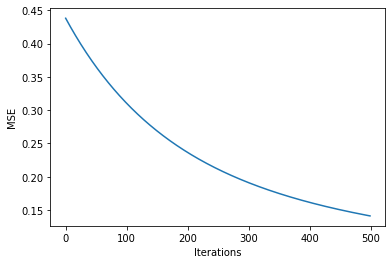

In [147]:
print("")

num_iter = 500
trained_prefs = latent_user_preferences.copy()
trained_feats = latent_item_features.copy()
trained_ratings = user_ratings.copy()

hist = sgd_m(num_iter, trained_prefs, trained_feats, trained_ratings)  #

plt.figure()
plt.plot(np.arange(0, num_iter), hist)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()

In [148]:
predictions = trained_prefs.dot(trained_feats.T)
predictions

Movie ID,11,12,13,14,22,24,38,63,77,85,...,8467,8587,9331,9741,9802,9806,10020,36657,36658,36955
User,,,,,,,,,,,,,,,,,,,,,
4768,0.647528,0.280737,-0.253771,-0.166044,-0.294969,-0.229673,0.126760,0.296619,0.358551,0.833180,...,0.762296,0.037798,0.091084,-0.127513,0.030545,0.426873,0.088046,-0.284609,-0.365477,0.097128
156,0.456291,0.098149,-0.203100,0.195359,0.000638,-0.322966,0.331272,0.263870,0.383304,-0.103314,...,-0.373896,0.099836,-0.096426,0.056650,-0.167688,-0.079801,-0.131647,-0.257720,-0.368720,-0.124821
5323,0.052425,0.077332,-0.038879,0.139939,0.400487,-0.042672,0.092499,-0.075725,0.125690,-0.039727,...,-0.281435,0.476495,-0.197940,-0.255566,-0.212400,0.040806,0.263822,-0.099578,-0.116951,-0.154752
174,-0.339692,-0.038858,0.166135,0.527690,0.240793,-0.012452,0.507110,0.359263,0.324422,-0.592256,...,-0.941099,-0.097886,-0.129239,0.226559,-0.229474,-0.245640,-0.133767,-0.059556,-0.041812,-0.472533
4529,-0.148138,0.258840,-0.090293,-0.037600,-0.026486,-0.579341,0.042831,-0.235874,0.076864,-0.271812,...,-0.326265,0.436490,-0.134467,-0.133355,-0.246755,0.236622,0.276181,0.203365,0.206199,-0.208507
783,-0.044558,0.066554,0.001486,0.065403,0.140730,-0.078126,0.001039,-0.088096,0.015963,-0.029874,...,0.169559,0.111438,-0.069751,-0.078834,-0.087217,0.032752,0.082081,-0.142212,-0.094841,-0.110290
3878,0.872822,0.421279,-0.211907,-0.658813,-0.287791,-0.149141,-0.200263,0.070920,0.205462,0.734138,...,1.003837,0.502150,0.036121,-0.260237,0.060368,0.484615,0.251987,-0.075078,-0.297194,0.309325
768,-0.001967,-0.009277,0.026312,0.059556,0.031146,-0.045821,0.022801,-0.037817,-0.005867,-0.001267,...,0.019916,0.059864,-0.017918,-0.030410,-0.043753,-0.058809,0.038099,-0.099030,-0.084632,0.003549
4469,-0.022073,-0.033270,0.032570,0.041874,0.001573,-0.062827,0.054080,0.008400,0.057605,-0.062549,...,0.061847,0.038686,-0.014718,-0.008960,-0.027918,-0.070361,0.004072,-0.051733,-0.048028,-0.043619


In [163]:
predictions.describe()

Movie ID,11,12,13,14,22,24,38,63,77,85,...,8467,8587,9331,9741,9802,9806,10020,36657,36658,36955
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,...,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.059284,0.080699,-0.029650,0.020668,0.078112,-0.257835,0.058318,-0.013941,0.132404,-0.040194,...,-0.136022,0.097792,-0.081763,-0.064634,-0.111692,0.036982,-0.017243,-0.040850,-0.056116,-0.125850
std,0.375444,0.150725,0.178058,0.288312,0.251519,0.401762,0.196992,0.221878,0.141419,0.447067,...,0.597717,0.271140,0.117040,0.119822,0.201746,0.215590,0.246707,0.226122,0.238477,0.309395
min,-1.019345,-0.274185,-0.256907,-0.658813,-0.294969,-1.517727,-0.404855,-0.637930,-0.235056,-1.211837,...,-1.983354,-0.446271,-0.444924,-0.294349,-0.771172,-0.480563,-0.510320,-0.606844,-0.612990,-1.124502
25%,-0.044558,-0.009277,-0.175749,-0.045071,-0.043592,-0.449190,0.022801,-0.088096,0.057605,-0.203714,...,-0.373896,-0.081455,-0.135388,-0.133355,-0.212400,-0.065043,-0.133767,-0.142212,-0.136105,-0.208507
50%,0.040824,0.077332,-0.038879,0.065403,0.031146,-0.062827,0.078861,0.008400,0.147748,-0.062549,...,-0.114729,0.059864,-0.087822,-0.032182,-0.072762,0.005543,0.038099,-0.059556,-0.084632,-0.102585
75%,0.210242,0.144216,0.032570,0.139939,0.159835,-0.035706,0.141555,0.094092,0.205462,0.086613,...,0.194536,0.205864,-0.012760,-0.000351,-0.027918,0.104675,0.098595,0.034602,0.039922,0.008520
max,0.872822,0.421279,0.373147,0.626066,0.724275,0.298529,0.507110,0.359263,0.383304,0.833180,...,1.003837,0.792567,0.139298,0.226559,0.403150,0.484615,0.542934,0.348680,0.400660,0.309325


In [ ]:
predictions.to_csv("movies_predictions.csv")

In [160]:
trained_ratings

,11,12,13,14,22,24,38,63,77,85,...,8467,8587,9331,9741,9802,9806,10020,36657,36658,36955
User ID,,,,,,,,,,,,,,,,,,,,,
4768,1.075866,0.490713,-0.514578,-0.370327,-0.088369,-0.171628,0.593612,0.149423,0.416629,0.129791,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156,0.510767,-0.125068,-0.151969,0.517930,0.189687,-0.260572,0.199863,-0.136578,0.910234,-0.637950,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5323,0.045008,-0.059968,-0.036395,0.247560,0.265635,-0.153931,0.271648,-0.302412,0.186516,-0.199164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
174,-0.075722,-0.052166,-0.353584,1.858963,-0.063346,0.000219,0.558233,-0.097778,-0.091951,-1.233248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4529,-0.211549,-0.511296,0.149259,-0.215623,0.003485,-0.564633,-0.017807,-0.236235,0.060928,-0.399136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
783,-0.128225,-0.055324,-0.017890,0.018573,0.161786,-0.105386,0.152208,-0.043136,0.027045,0.101489,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3878,0.928983,0.326437,-0.065310,-1.992433,0.032120,-0.113857,0.345319,0.071474,0.562888,0.670933,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
768,-0.039545,-0.047596,0.099078,0.017030,0.050608,-0.055531,0.014937,0.002273,0.012196,0.048750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4469,-0.060360,0.019270,0.010936,0.021893,0.038589,-0.054131,0.158589,-0.018854,0.008534,-0.002490,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [161]:
pred_trained: pd.DataFrame = pd.DataFrame(predictions.values - trained_ratings.values)


pred_trained

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.428338,-0.209976,0.260807,0.204283,-0.206600,-0.058045,-0.466851,0.147196,-0.058078,0.703389,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.054476,0.223218,-0.051131,-0.322571,-0.189049,-0.062393,0.131408,0.400447,-0.526930,0.534636,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.007418,0.137301,-0.002484,-0.107621,0.134853,0.111259,-0.179149,0.226687,-0.060826,0.159437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.263970,0.013308,0.519719,-1.331272,0.304139,-0.012671,-0.051123,0.457042,0.416373,0.640992,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.063411,0.770136,-0.239552,0.178023,-0.029971,-0.014708,0.060638,0.000361,0.015936,0.127323,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.083667,0.121878,0.019376,0.046830,-0.021056,0.027260,-0.151169,-0.044960,-0.011081,-0.131363,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,-0.056161,0.094842,-0.146596,1.333620,-0.319911,-0.035284,-0.545583,-0.000554,-0.357427,0.063204,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.037578,0.038319,-0.072766,0.042526,-0.019462,0.009711,0.007864,-0.040091,-0.018063,-0.050017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.038287,-0.052540,0.021634,0.019981,-0.037016,-0.008696,-0.104510,0.027254,0.049071,-0.060059,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.146520,0.299718,-0.054247,0.201576,0.085968,-0.001489,0.088208,0.402828,-0.113898,0.086543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [162]:
pred_trained.describe()


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,-0.124276,0.134740,0.056232,0.128342,-0.058867,-0.018940,-0.244283,0.135448,0.101105,0.289644,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.222510,0.281445,0.200366,0.640171,0.191001,0.099538,0.430058,0.257683,0.383069,0.456854,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-0.634568,-0.243350,-0.241444,-1.331272,-0.617310,-0.264705,-1.657771,-0.373356,-0.526930,-0.280883,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,-0.243395,-0.032535,-0.054247,-0.128860,-0.137640,-0.035284,-0.466851,-0.000554,-0.060826,-0.045092,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,-0.019066,0.074401,0.006760,0.061101,-0.040579,-0.007630,-0.101960,0.147196,0.049071,0.159437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,0.037578,0.223218,0.152382,0.204283,-0.012879,0.011946,0.035022,0.227755,0.300782,0.534636,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,0.154019,0.891728,0.519719,1.529817,0.382696,0.166554,0.150487,0.864918,1.420167,1.770766,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [171]:
values = [
    zip(trained_ratings[i], predictions[i])
    for i in predictions.columns.values
]
comparison_data: pd.DataFrame = pd.DataFrame(values)
#comparison_data.columns = data.columns


In [172]:
comparison_data
# For each data point, the number on the left is the original value from the dataset, the number on the right is the prediction

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,"(1.0758658101649137, 0.6475279176527022)","(0.5107669284264952, 0.4562912124291363)","(0.045007688300748055, 0.052425472619597)","(-0.07572176257045696, -0.3396916776393251)","(-0.21154872369774647, -0.14813774059402215)","(-0.1282253332042605, -0.04455801943693378)","(0.9289827867793355, 0.8728221669752763)","(-0.03954520226214034, -0.0019667836461362007)","(-0.060359741766864955, -0.02207282023743043)","(-0.14860447504878796, -0.002084575807038979)",...,"(0.17840710699561912, 0.15934074297286346)","(-0.32723079080280715, -0.17321133219076726)","(0.12526186292756158, 0.1267006282475712)","(1.0655785146297094, 0.4709215831358006)","(0.22597098567117974, 0.21024218214927887)","(-0.055370387512947095, -0.016554139753538706)","(0.8045375250993225, 0.41181923507554596)","(0.3076411982459665, -0.09611301651666931)","(0.2122131621226882, 0.24855077721027122)","(0.2126509169881207, 0.04082440011799531)"
1,"(0.49071264831648176, 0.28073693584028725)","(-0.12506848830463702, 0.09814918056413985)","(-0.05996840216776039, 0.07733224978657441)","(-0.05216619321257909, -0.03885797867748317)","(-0.5112962864391648, 0.25883956973947947)","(-0.055323892856136765, 0.06655420982061627)","(0.3264372101232124, 0.4212787252246851)","(-0.0475955923501756, -0.009276511788633729)","(0.019269700170511814, -0.03327029843010993)","(-0.07796000808794651, 0.22175816686833877)",...,"(0.03407908653356848, -0.008454689073913417)","(-0.035768425197107975, 0.10752919853865119)","(-0.14394949579247912, -0.07092423986388768)","(-0.1343383705808876, 0.1412643021736394)","(0.25323484119694684, 0.1442157992138058)","(0.03480907214253558, 0.025979812706269142)","(-0.3653791592364735, 0.25495500595315923)","(0.273975870536001, 0.030626302108868218)","(-0.08237029580723865, -0.00796972063356266)","(0.07495853389071847, 0.1008920372059679)"
2,"(-0.514578191563571, -0.25377140055724295)","(-0.15196877590348545, -0.20309964494558497)","(-0.03639548489365921, -0.03887933284290204)","(-0.35358448304621354, 0.16613494746011587)","(0.1492589639044261, -0.09029284521133281)","(-0.01789032315430581, 0.0014856355914944824)","(-0.0653104827938566, -0.21190660704953335)","(0.09907837413201344, 0.02631237823568935)","(0.010935657033179932, 0.03256977575259193)","(-0.11615252960004732, -0.17039963829332003)",...,"(0.01665737218738527, -0.03150971991105411)","(-0.12919858825976435, -0.12243879517666421)","(-0.12491061997174097, -0.08460942889549612)","(-0.42448267481346896, -0.20772985223525237)","(-0.14367941985374022, -0.1921339357233856)","(0.13202104614651378, 0.05859360153130513)","(0.3358286678801888, 0.37314690112045074)","(-0.6034441843058787, -0.17574949020305683)","(0.05970610108894871, -0.014549382388321984)","(-0.0297052348336908, 0.03088956548591958)"
3,"(-0.3703265218330274, -0.16604372767877126)","(0.5179297697515699, 0.1953589154585705)","(0.24756013790854714, 0.13993875197821182)","(1.8589625635968519, 0.5276903308871039)","(-0.2156232469953096, -0.037600218898158684)","(0.01857321747309184, 0.06540341658683468)","(-1.9924328167852674, -0.658812827577213)","(0.017029778487458905, 0.059556073276464526)","(0.021892631145999698, 0.04187406377669062)","(-0.09469973350853758, 0.10687644096218837)",...,"(0.04553260906565146, 0.15020618363496857)","(0.23244150573641598, 0.1317206823413683)","(0.007842373892269883, 0.06894367395240501)","(0.01499687339095146, -0.11386354024034119)","(0.48778482288839453, 0.28627520910463616)","(-0.18608846014764974, 0.042412098607838705)","(-2.0002042442158405, -0.4764821398695455)","(-0.10991577209461195, -0.04507078365994068)","(-0.05341738577543431, 0.22798978221826388)","(0.004692881044760108, 0.07035301743732031)"
4,"(-0.08836942705898741, -0.2949692024941475)","(0.18968696831776002, 0.000637898572780394)","(0.26563453899399375, 0.40048708239078473)","(-0.0633464616421604, 0.2407926776602226)","(0.0034849785902189845, -0.026486037863977813)","(0.1617856534868373, 0.1407301210335

In [ ]:
comparison_data.to_csv(
    "trained_comparison_data.csv"
)